In [ ]:
pip install matplotlib

In [1]:
import pyodbc

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import random
import os


In [14]:
results = []

def evaluate_model(name, y_true, y_pred, alpha=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({
        'Модель': name,
        'R²': round(r2, 4),
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MSE': round(mse, 2),
        'alpha': alpha if alpha is not None else "-"
    })

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
conn = pyodbc.connect("DSN=vertica")
query_train = "SELECT * FROM cards_2011_2023_plus"
query_test = "SELECT * FROM cards_2011_2023_2024_plus"

df_train = pd.read_sql(query_train, conn)
df_test = pd.read_sql(query_test, conn)

df_train = df_train.select_dtypes(exclude=['object'])
df_test = df_test.select_dtypes(exclude=['object'])

features_to_scale = ['dow', 'n_year_week', 'n_month_week', 'n_week_week', 'prih_unt_int','prih_rub_int','mkdn_unt_int','mkdn_rub_int','discount_rub_int','apoh_int','eoh_unt_int','eoh_rub_int','discount_rub_prc','mkdn_rub_int_5days','sms','st_area','napoln','napoln_rub','cr','sls_rub_int_year','visiors_year','sls_rub_online','sls_unt_online','sls_rub_online_prc','sls_unt_online_prc']

scaler = RobustScaler()
# scaler = StandardScaler()
scaler.fit(df_train[features_to_scale])

df_train_scaled = df_train.copy()
df_train_scaled[features_to_scale] = scaler.transform(df_train_scaled[features_to_scale])

df_test_scaled = df_test.copy()
df_test_scaled[features_to_scale] = scaler.transform(df_test_scaled[features_to_scale])

# Преобразуем месяц и день недели в циклические признаки
df_train_scaled['month_sin'] = np.sin(2 * np.pi * df_train['n_month_week'] / 12)
df_train_scaled['month_cos'] = np.cos(2 * np.pi * df_train['n_month_week'] / 12)

df_train_scaled['dow_sin'] = np.sin(2 * np.pi * df_train['dow'] / 7)
df_train_scaled['dow_cos'] = np.cos(2 * np.pi * df_train['dow'] / 7)

df_train_scaled['n_week_week_sin'] = np.sin(2 * np.pi * df_train['n_week_week'] / 52)
df_train_scaled['n_week_week_cos'] = np.cos(2 * np.pi * df_train['n_week_week'] / 52)

df_test_scaled['month_sin'] = np.sin(2 * np.pi * df_test['n_month_week'] / 12)
df_test_scaled['month_cos'] = np.cos(2 * np.pi * df_test['n_month_week'] / 12)

df_test_scaled['dow_sin'] = np.sin(2 * np.pi * df_test['dow'] / 7)
df_test_scaled['dow_cos'] = np.cos(2 * np.pi * df_test['dow'] / 7)

df_test_scaled['n_week_week_sin'] = np.sin(2 * np.pi * df_test['n_week_week'] / 52)
df_test_scaled['n_week_week_cos'] = np.cos(2 * np.pi * df_test['n_week_week'] / 52)

features_to_scale2 = ['n_week_week_sin', 'n_week_week_cos', 'month_sin', 'month_cos','dow_sin', 'dow_cos', 'prih_rub_int','discount_rub_int', 'eoh_rub_int', 'discount_rub_prc', 'mkdn_rub_int_5days', 'eoh_unt_int', 'st_area', 'napoln', 'apoh_int', 'sls_rub_online_prc', 'sls_unt_online_prc','sls_rub_int_year', 'sms']

C:\Users\zubchenko\AppData\Local\Temp\ipykernel_14552\2883158923.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_train = pd.read_sql(query_train, conn)
C:\Users\zubchenko\AppData\Local\Temp\ipykernel_14552\2883158923.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_test = pd.read_sql(query_test, conn)


In [5]:
X_train = df_train_scaled[features_to_scale2]
#Y_train = np.log1p(df_train_scaled['visiors'])
Y_train = df_train_scaled['visiors']

X_test = df_test_scaled[features_to_scale2]
Y_test = df_test_scaled['visiors']

In [6]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # без активации, т.к. регрессия
])

model.compile(optimizer='adam', loss='huber', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    #callbacks=[early_stopping],
    verbose=1
)

Y_pred = model.predict(X_test).flatten()

print("Нейросеть:")
print("  R2:", r2_score(Y_test, Y_pred))
print("  MSE:", mean_squared_error(Y_test, Y_pred))

Epoch 1/300


c:\Users\zubchenko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 474862.6875 - mae: 474863.0938 - val_loss: 478718.7812 - val_mae: 478719.1875
Epoch 2/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 479116.7500 - mae: 479117.2812 - val_loss: 476671.7188 - val_mae: 476672.2188
Epoch 3/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 473995.9375 - mae: 473996.5625 - val_loss: 470213.9688 - val_mae: 470214.3750
Epoch 4/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 460876.7812 - mae: 460877.2500 - val_loss: 457520.7188 - val_mae: 457521.1875
Epoch 5/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 445244.9375 - mae: 445245.4062 - val_loss: 436834.8438 - val_mae: 436835.3438
Epoch 6/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 430333.6875 - mae: 430334.1250 - val_loss: 419003.1875 - val_mae: 419003.6250
Epoch 7/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 402665.9688 - mae: 402666.4688 - val_loss: 407929.8750 - val_mae: 407930.3750
Epoch 8/300
110/110 ━━━━━━━━━━━━━━━━━━━

In [11]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

history = model.fit(
    X_train, Y_train,
    validation_split=0.15,
    epochs=500,
    batch_size=32,
    verbose=1
)

Y_pred = model.predict(X_test).flatten()

print("Нейросеть:")
print("  R2:", r2_score(Y_test, Y_pred))
print("  MSE:", mean_squared_error(Y_test, Y_pred))

Epoch 1/500


c:\Users\zubchenko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 478309.0938 - mae: 478309.6875 - val_loss: 408772.0312 - val_mae: 408772.5312
Epoch 2/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 362548.3750 - mae: 362548.9375 - val_loss: 243507.1562 - val_mae: 243507.6719
Epoch 3/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 203860.9062 - mae: 203861.4219 - val_loss: 141591.6094 - val_mae: 141592.1094
Epoch 4/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133482.6875 - mae: 133483.1875 - val_loss: 107005.1406 - val_mae: 107005.6406
Epoch 5/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109865.4922 - mae: 109865.9922 - val_loss: 89208.8906 - val_mae: 89209.3906
Epoch 6/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92975.6250 - mae: 92976.1250 - val_loss: 77695.9375 - val_mae: 77696.4453
Epoch 7/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79379.1250 - mae: 79379.6250 - val_loss: 68359.5469 - val_mae: 68360.0391
Epoch 8/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

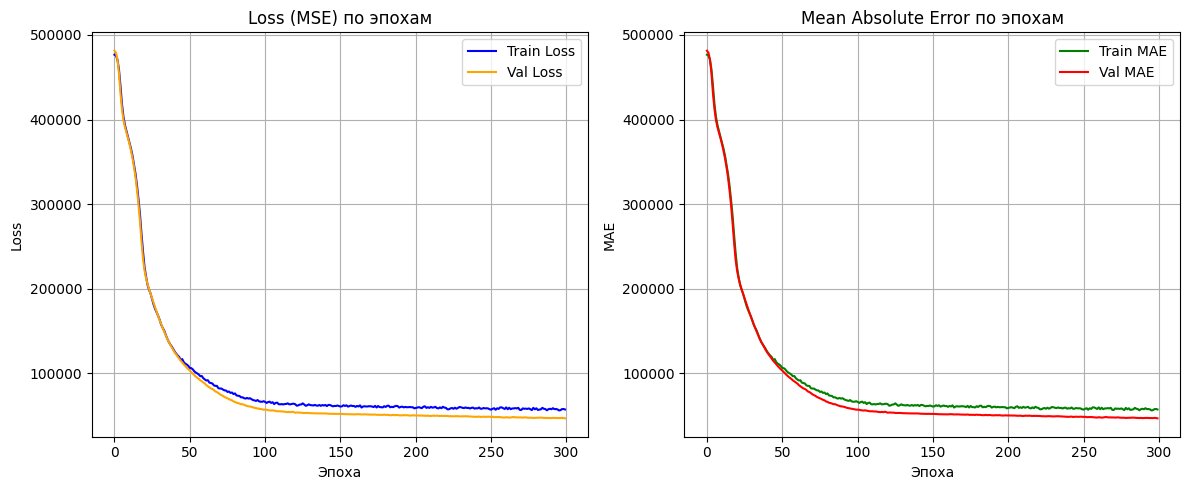

In [38]:
# Построим график ошибки (loss)
plt.figure(figsize=(12, 5))
 
# --- График потерь ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss (MSE) по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
 
# --- График MAE ---
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Mean Absolute Error по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
 
plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


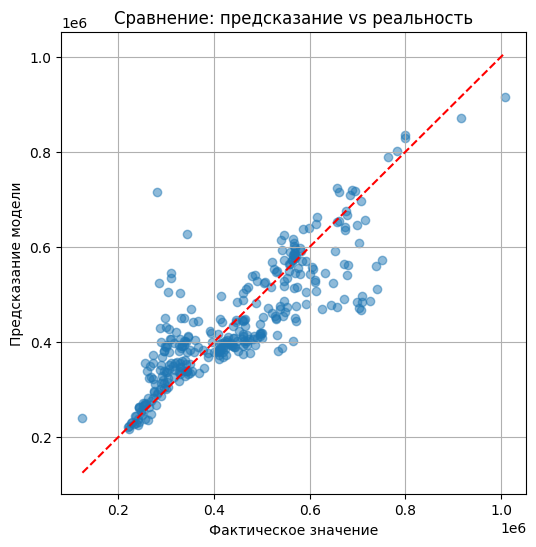

In [27]:
y_pred = model.predict(X_test).flatten()
 
plt.figure(figsize=(6, 6))
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel("Фактическое значение")
plt.ylabel("Предсказание модели")
plt.title("Сравнение: предсказание vs реальность")
plt.grid(True)
plt.show()

In [21]:
results = []

evaluate_model('Нейросеть:', Y_test, Y_pred)
df_results = pd.DataFrame(results)
print(df_results)

       Модель      R²       MAE      RMSE           MSE alpha
0  Нейросеть:  0.8205  49210.61  62644.19  3.924295e+09     -
